In [1]:
pip uninstall imbalanced-learn scikit-learn

^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install imbalanced-learn scikit-learn

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import skew
import  seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn import metrics
import numpy as np
import pickle

In [2]:
df = pd.read_excel('Copper_Set.xlsx')

In [3]:
df.head()

,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,20210401.0,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,20210701.0,854.00
1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,20210401.0,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,0000000000000000000000000000000000104991,1668701718,20210401.0,1047.00
2,E140FF1B-2407-4C02-A0DD-780A093B1158,20210401.0,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,S0380700,628377,20210101.0,644.33
3,F8D507A0-9C62-4EFE-831E-33E1DA53BB50,20210401.0,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,DX51D+ZM310MAO 2.3X1317,1668701718,20210101.0,768.00
4,4E1C4E78-152B-430A-8094-ADD889C9D0AD,20210401.0,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,2_S275JR+AR-CL1,640665,20210301.0,577.00


In [4]:
for i in list(df.columns):
    print(f"{i} : {df[i].nunique()}")

id : 181671
item_date : 252
quantity tons : 181673
customer : 1169
country : 17
status : 9
item type : 7
application : 30
thickness : 594
width : 1386
material_ref : 16563
product_ref : 33
delivery date : 28
selling_price : 9795


In [5]:
df['quantity tons'] = pd.to_numeric(df['quantity tons'], errors ='coerce')
df['customer'] = pd.to_numeric(df['customer'], errors = 'coerce')
df['country'] = pd.to_numeric(df['country'], errors = 'coerce')
df['item_date'] = pd.to_datetime(df['item_date'], format='%Y%m%d', errors='coerce').dt.date
df['delivery date'] = pd.to_datetime(df['delivery date'], format='%Y%m%d', errors='coerce').dt.date

In [6]:
df['item_date'] = pd.to_datetime(df['item_date'])
df['delivery date'] = pd.to_datetime(df['delivery date'])
df['delivery_time_taken'] = (df['item_date']-df['delivery date']).abs().dt.days

In [7]:
df.dtypes

id                             object
item_date              datetime64[ns]
quantity tons                 float64
customer                      float64
country                       float64
status                         object
item type                      object
application                   float64
thickness                     float64
width                         float64
material_ref                   object
product_ref                     int64
delivery date          datetime64[ns]
selling_price                 float64
delivery_time_taken           float64
dtype: object

In [8]:
df.isnull().sum()

id                         2
item_date                  3
quantity tons              1
customer                   1
country                   28
status                     2
item type                  0
application               24
thickness                  1
width                      0
material_ref           77919
product_ref                0
delivery date              3
selling_price              1
delivery_time_taken        6
dtype: int64

In [9]:
df['material_ref'] = df['material_ref'].apply(lambda x: np.nan if str(x).startswith('0000') else x)
df.isnull().sum()

id                          2
item_date                   3
quantity tons               1
customer                    1
country                    28
status                      2
item type                   0
application                24
thickness                   1
width                       0
material_ref           100645
product_ref                 0
delivery date               3
selling_price               1
delivery_time_taken         6
dtype: int64

In [10]:
df.drop(columns = ['id','item_date','delivery date','material_ref'], inplace = True)
df

,quantity tons,customer,country,status,item type,application,thickness,width,product_ref,selling_price,delivery_time_taken
0,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,1670798778,854.00,91.0
1,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,1668701718,1047.00,0.0
2,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,628377,644.33,90.0
3,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,1668701718,768.00,90.0
4,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,640665,577.00,31.0
...,...,...,...,...,...,...,...,...,...,...,...
181668,102.482422,30200854.0,25.0,Won,W,41.0,0.96,1220.0,164141591,591.00,1.0
181669,208.086469,30200854.0,25.0,Won,W,41.0,0.95,1500.0,164141591,589.00,1.0
181670,4.235594,30200854.0,25.0,Won,W,41.0,0.71,1250.0,164141591,619.00,1.0
181671,-2000.000000,30200854.0,25.0,Won,W,41.0,0.85,1250.0,164141591,601.00,1.0


In [11]:
df.describe()

,quantity tons,customer,country,application,thickness,width,product_ref,selling_price,delivery_time_taken
count,1.816720e+05,1.816720e+05,181645.000000,181649.000000,181672.000000,181673.000000,1.816730e+05,1.816720e+05,181667.000000
mean,5.874926e+03,3.051221e+07,44.893022,25.615809,2.564827,1295.286724,4.739679e+08,1.918036e+03,64.131279
std,2.349081e+06,2.433382e+07,24.404214,17.754175,6.572321,261.631754,7.175101e+08,3.317956e+05,40.958608
min,-2.000000e+03,1.245800e+04,25.000000,2.000000,0.180000,1.000000,6.117280e+05,-1.160000e+03,0.000000
25%,1.097030e+01,3.019688e+07,26.000000,10.000000,0.700000,1180.000000,6.119930e+05,6.690000e+02,29.000000
50%,3.036464e+01,3.020524e+07,30.000000,15.000000,1.500000,1250.000000,6.406650e+05,8.120000e+02,61.000000
75%,6.716061e+01,3.028042e+07,78.000000,41.000000,3.000000,1500.000000,1.332077e+09,9.530000e+02,97.000000
max,1.000000e+09,2.147484e+09,113.000000,99.000000,2500.000000,2990.000000,1.722208e+09,1.000010e+08,689.000000


In [12]:
df['quantity tons'] = df['quantity tons'].apply(lambda x : np.nan if x <=0 else x)
df['selling_price'] = df['selling_price'].apply(lambda x : np.nan if x <= 0 else x )
df.describe()

,quantity tons,customer,country,application,thickness,width,product_ref,selling_price,delivery_time_taken
count,1.816680e+05,1.816720e+05,181645.000000,181649.000000,181672.000000,181673.000000,1.816730e+05,1.816650e+05,181667.000000
mean,5.875066e+03,3.051221e+07,44.893022,25.615809,2.564827,1295.286724,4.739679e+08,1.918124e+03,64.131279
std,2.349107e+06,2.433382e+07,24.404214,17.754175,6.572321,261.631754,7.175101e+08,3.318020e+05,40.958608
min,1.000000e-05,1.245800e+04,25.000000,2.000000,0.180000,1.000000,6.117280e+05,1.000000e-01,0.000000
25%,1.097122e+01,3.019688e+07,26.000000,10.000000,0.700000,1180.000000,6.119930e+05,6.690000e+02,29.000000
50%,3.036501e+01,3.020524e+07,30.000000,15.000000,1.500000,1250.000000,6.406650e+05,8.120000e+02,61.000000
75%,6.716134e+01,3.028042e+07,78.000000,41.000000,3.000000,1500.000000,1.332077e+09,9.530000e+02,97.000000
max,1.000000e+09,2.147484e+09,113.000000,99.000000,2500.000000,2990.000000,1.722208e+09,1.000010e+08,689.000000


In [13]:
df.isnull().sum()

quantity tons           5
customer                1
country                28
status                  2
item type               0
application            24
thickness               1
width                   0
product_ref             0
selling_price           8
delivery_time_taken     6
dtype: int64

In [14]:
df['status'].fillna(df['status'].mode().iloc[0],inplace = True)
df['quantity tons'].fillna(df['quantity tons'].median(),inplace=True)
df['customer'].fillna(df['customer'].median(),inplace= True)
df['country'].fillna(df['country'].median(),inplace=True)
df['application'].fillna(df['application'].median(), inplace=True)
df['thickness'].fillna(df['thickness'].median(),inplace = True)
df['selling_price'].fillna(df['selling_price'].median(), inplace = True)
df['delivery_time_taken'].fillna(df['delivery_time_taken'].median(),inplace=True)

In [15]:
df.isnull().sum()

quantity tons          0
customer               0
country                0
status                 0
item type              0
application            0
thickness              0
width                  0
product_ref            0
selling_price          0
delivery_time_taken    0
dtype: int64

In [16]:
df1 = df.copy()
df1.head()

,quantity tons,customer,country,status,item type,application,thickness,width,product_ref,selling_price,delivery_time_taken
0,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,1670798778,854.00,91.0
1,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,1668701718,1047.00,0.0
2,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,628377,644.33,90.0
3,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,1668701718,768.00,90.0
4,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,640665,577.00,31.0


In [17]:
for col in ['quantity tons', 'customer', 'country', 'application', 'thickness', 'width','product_ref', 'selling_price','delivery_time_taken']:
    print(col)
    print(skew(df1[col]))

quantity tons
424.68730994731504
customer
86.9845901502091
country
0.7538286488466676
application
0.7245583983073829
thickness
303.4450657126513
width
0.37459367901082125
product_ref
1.0152071910463223
selling_price
301.38559971625915
delivery_time_taken
0.46972996509615955


In [18]:
def plot(df, column):
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    sns.boxplot(data=df, x=column)
    plt.title(f'Box Plot for {column}')

    plt.subplot(1,3,2)
    sns.histplot(data=df, x=column, kde=True, bins=50)
    plt.title(f'Distribution Plot for {column}')

    plt.subplot(1,3,3)
    sns.violinplot(data=df, x=column)
    plt.title(f'Violin Plot for {column}')
    plt.show()

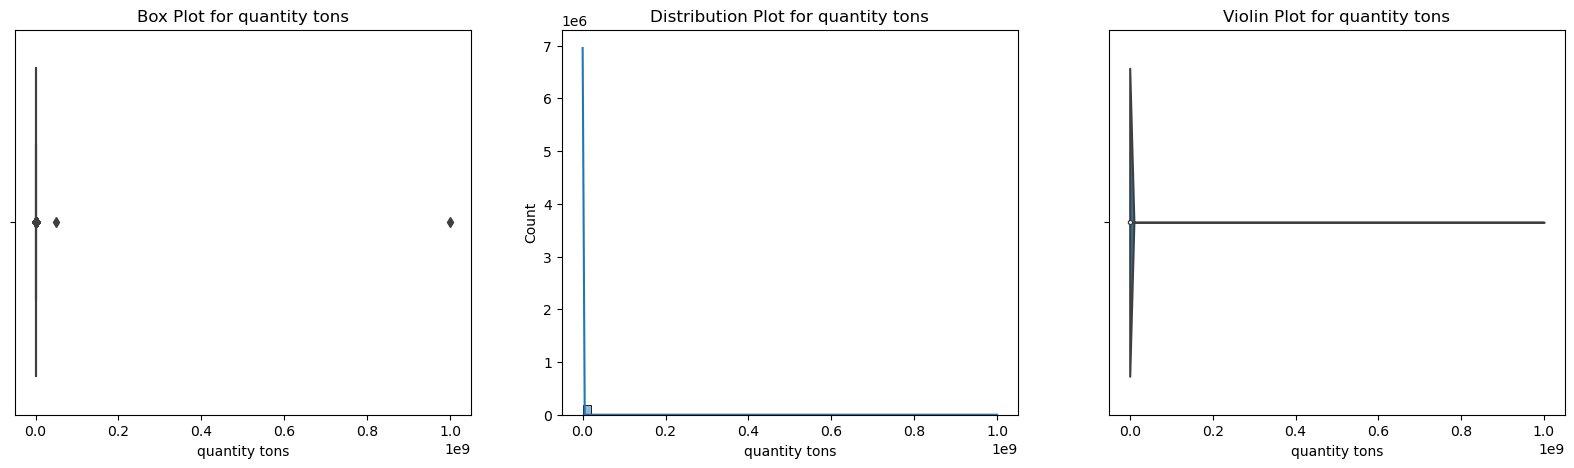

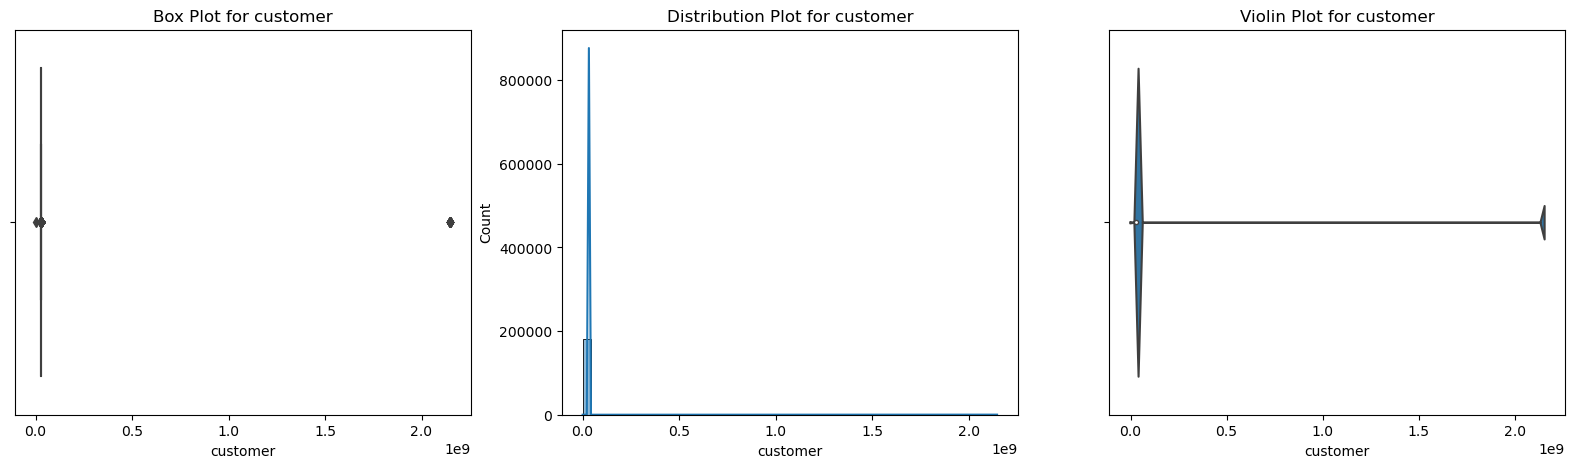

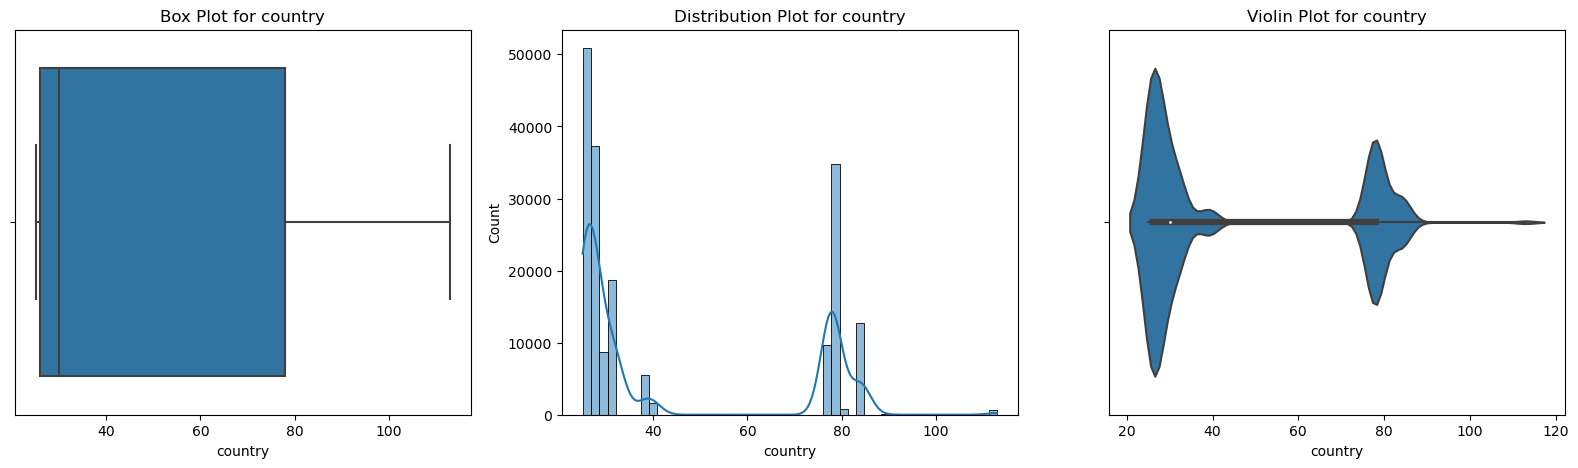

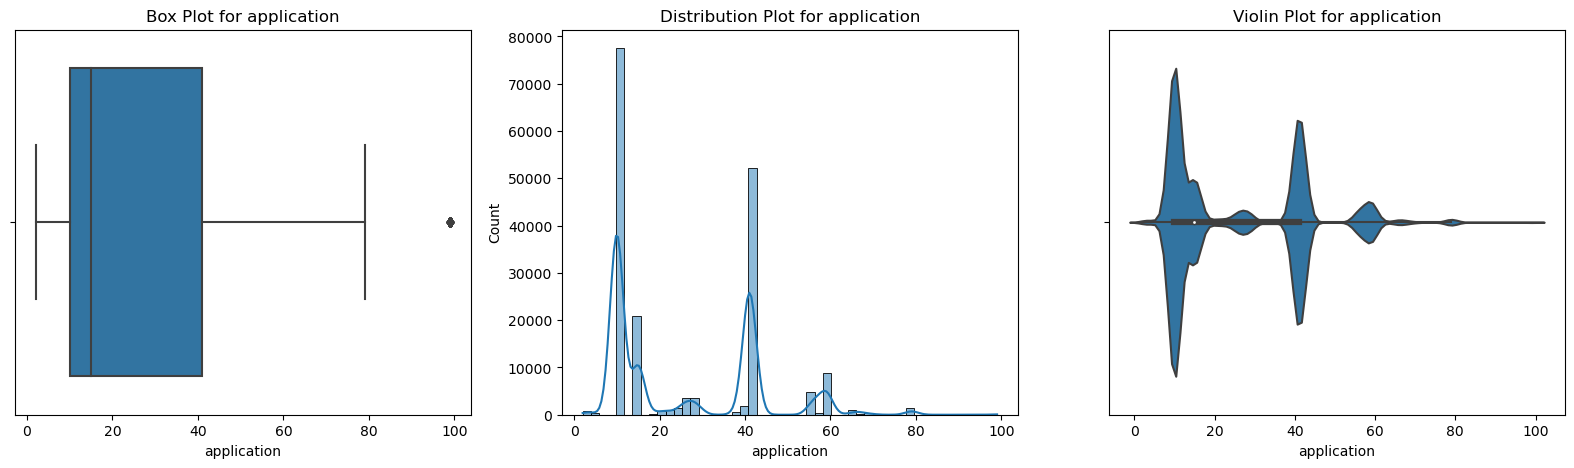

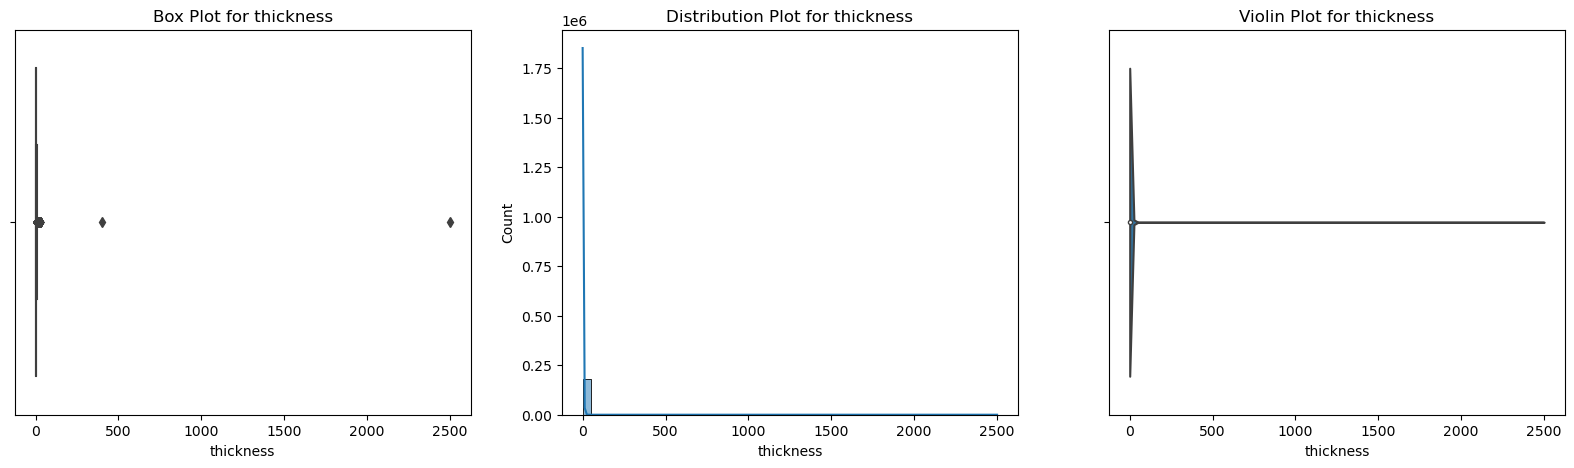

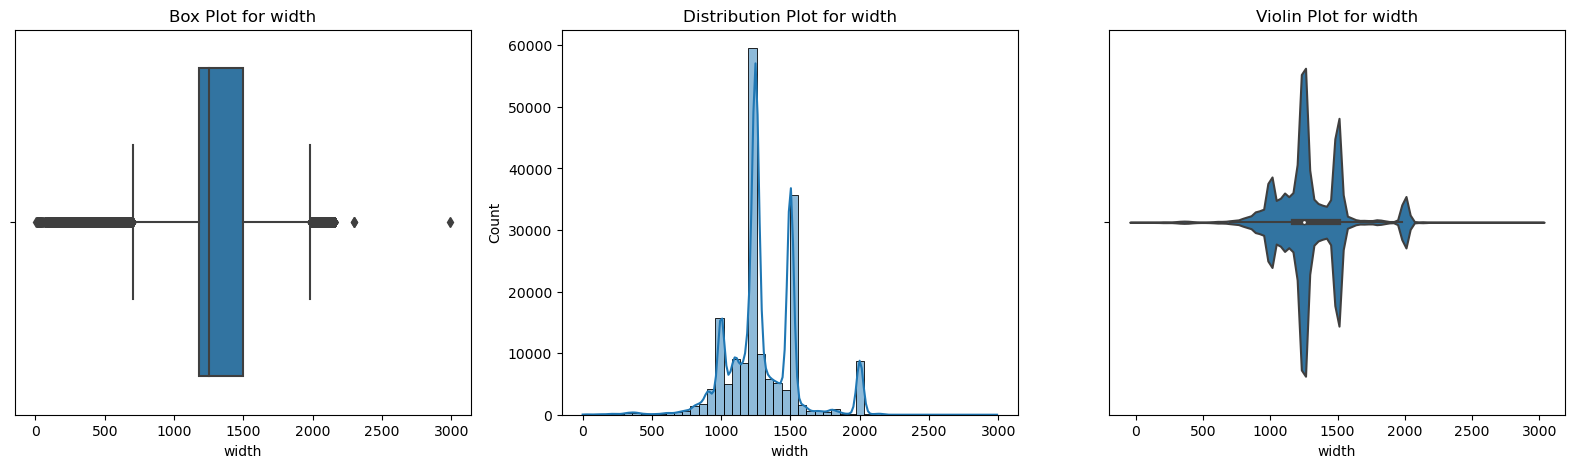

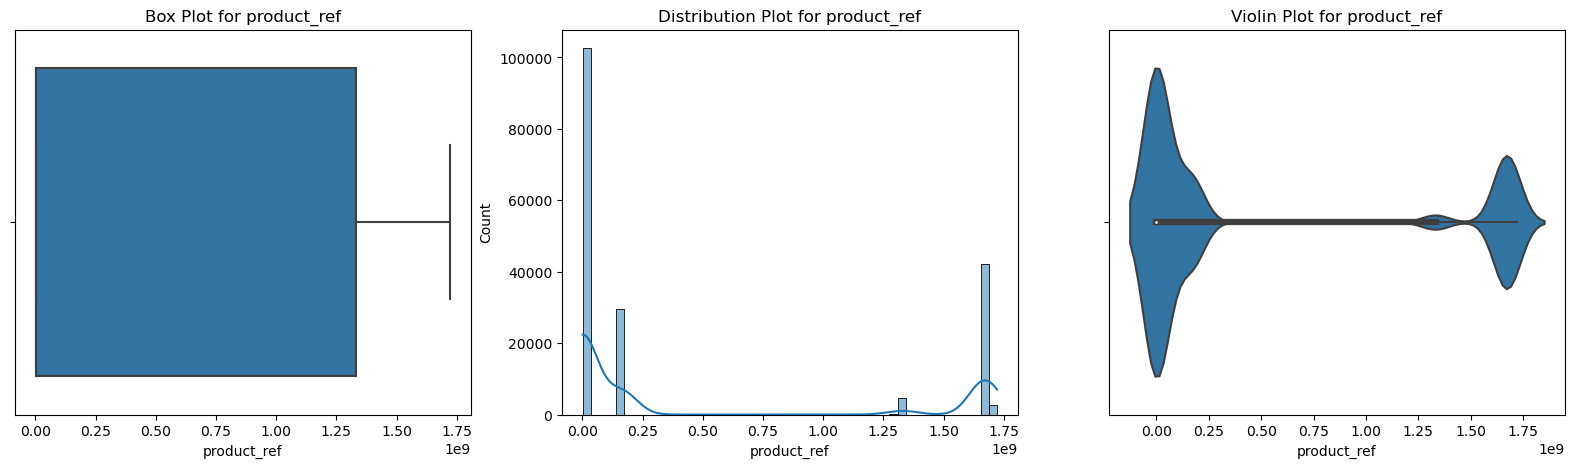

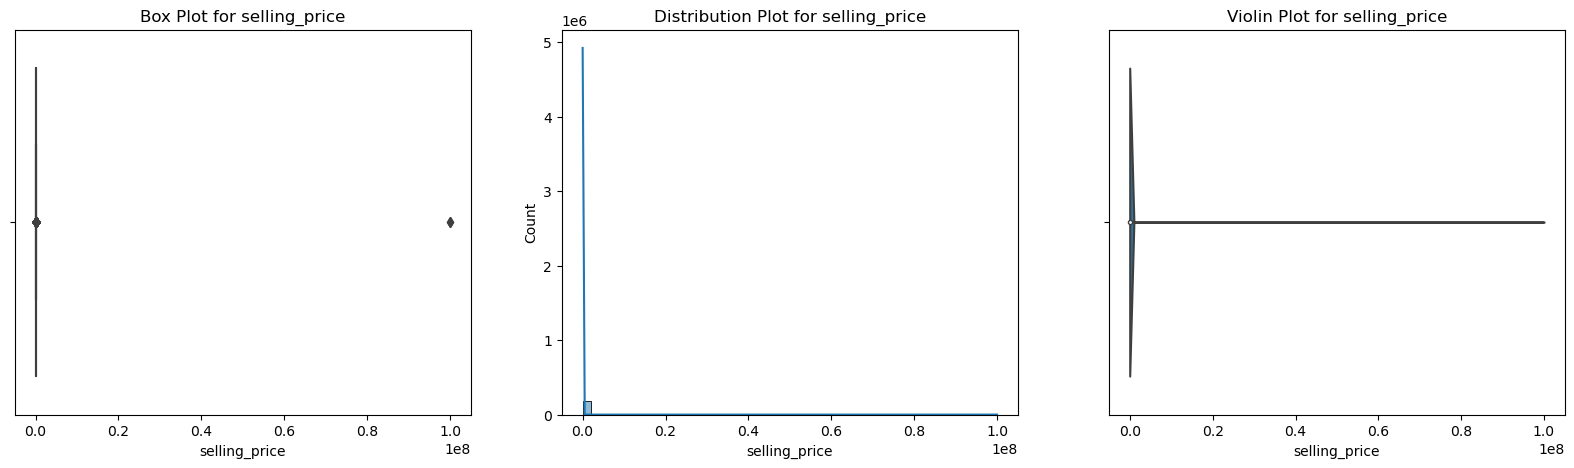

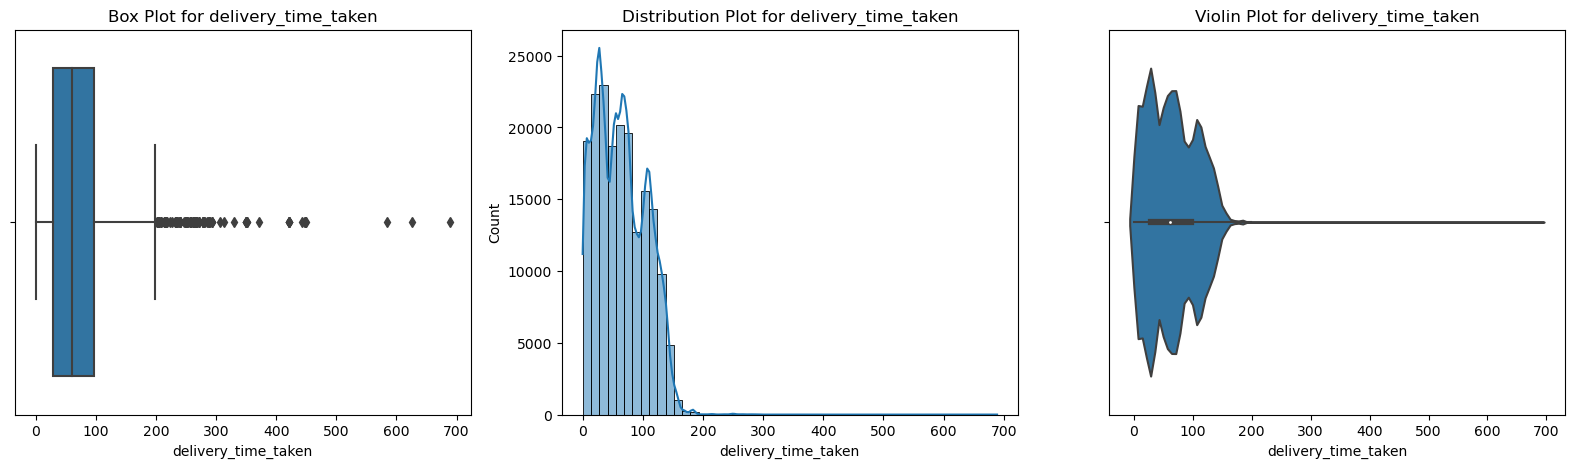

In [19]:
for i in ['quantity tons', 'customer', 'country', 'application', 'thickness', 'width','product_ref', 'selling_price','delivery_time_taken']:
    plot(df1, i)

In [20]:
df1['quantity_tons_log']=np.log(df1['quantity tons'])
df1['thickness_log']=np.log(df1['thickness'])
df1['selling_price_log']=np.log(df1['selling_price'])
df1.head()

,quantity tons,customer,country,status,item type,application,thickness,width,product_ref,selling_price,delivery_time_taken,quantity_tons_log,thickness_log,selling_price_log
0,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,1670798778,854.00,91.0,3.991779,0.693147,6.749931
1,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,1668701718,1047.00,0.0,6.643822,-0.223144,6.953684
2,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,628377,644.33,90.0,5.956169,-0.967584,6.468211
3,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,1668701718,768.00,90.0,5.310301,0.832909,6.643790
4,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,640665,577.00,31.0,6.666354,1.386294,6.357842


In [21]:
df1.drop(columns=['quantity tons','thickness','selling_price'], inplace=True)
df1.head()

,customer,country,status,item type,application,width,product_ref,delivery_time_taken,quantity_tons_log,thickness_log,selling_price_log
0,30156308.0,28.0,Won,W,10.0,1500.0,1670798778,91.0,3.991779,0.693147,6.749931
1,30202938.0,25.0,Won,W,41.0,1210.0,1668701718,0.0,6.643822,-0.223144,6.953684
2,30153963.0,30.0,Won,WI,28.0,952.0,628377,90.0,5.956169,-0.967584,6.468211
3,30349574.0,32.0,Won,S,59.0,1317.0,1668701718,90.0,5.310301,0.832909,6.643790
4,30211560.0,28.0,Won,W,10.0,2000.0,640665,31.0,6.666354,1.386294,6.357842


In [22]:
def outlier(df, column):
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    upper_threshold = df[column].quantile(0.75) + (1.5*iqr)
    lower_threshold = df[column].quantile(0.25) - (1.5*iqr)
    df[column] = df[column].clip(lower_threshold, upper_threshold)

In [23]:
outlier(df1,'quantity_tons_log')
outlier(df1,'thickness_log')
outlier(df1,'selling_price_log')
outlier(df1,'width')
df1

,customer,country,status,item type,application,width,product_ref,delivery_time_taken,quantity_tons_log,thickness_log,selling_price_log
0,30156308.0,28.0,Won,W,10.0,1500.0,1670798778,91.0,3.991779,0.693147,6.749931
1,30202938.0,25.0,Won,W,41.0,1210.0,1668701718,0.0,6.643822,-0.223144,6.953684
2,30153963.0,30.0,Won,WI,28.0,952.0,628377,90.0,5.956169,-0.967584,6.468211
3,30349574.0,32.0,Won,S,59.0,1317.0,1668701718,90.0,5.310301,0.832909,6.643790
4,30211560.0,28.0,Won,W,10.0,1980.0,640665,31.0,6.666354,1.386294,6.357842
...,...,...,...,...,...,...,...,...,...,...,...
181668,30200854.0,25.0,Won,W,41.0,1220.0,164141591,1.0,4.629691,-0.040822,6.381816
181669,30200854.0,25.0,Won,W,41.0,1500.0,164141591,1.0,5.337954,-0.051293,6.378426
181670,30200854.0,25.0,Won,W,41.0,1250.0,164141591,1.0,1.443523,-0.342490,6.428105
181671,30200854.0,25.0,Won,W,41.0,1250.0,164141591,1.0,3.413291,-0.162519,6.398595


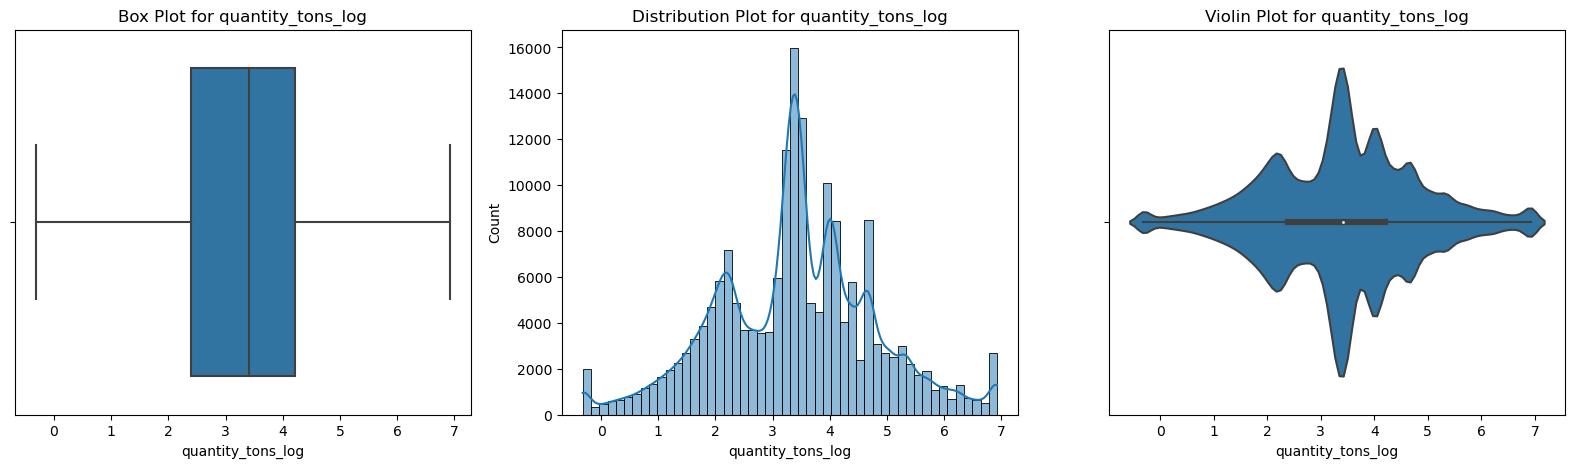

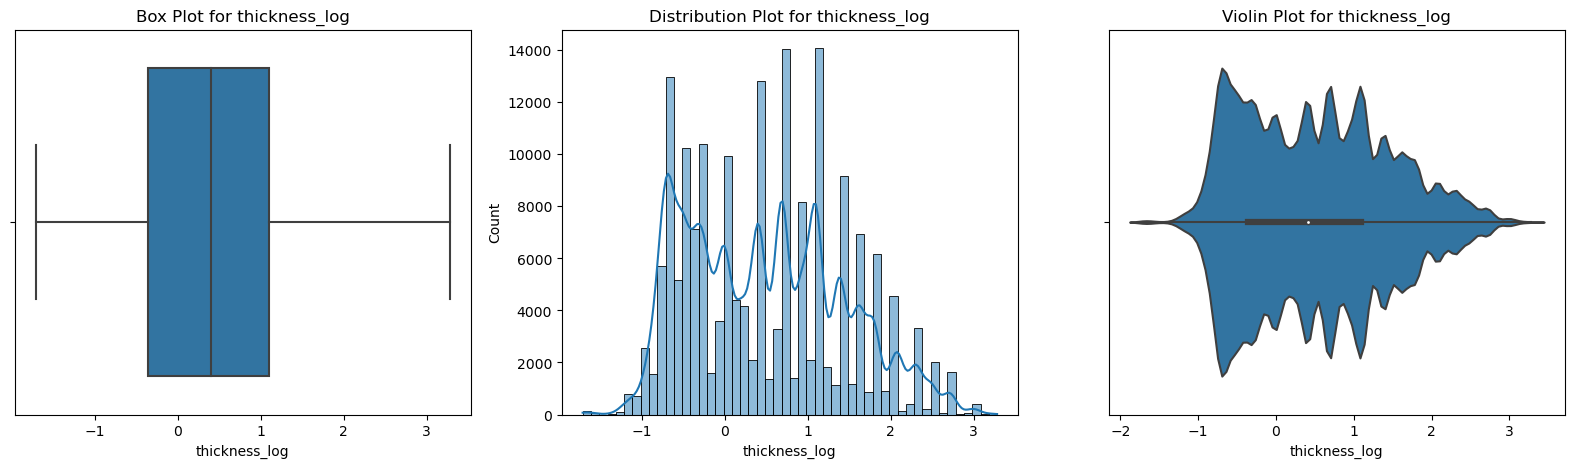

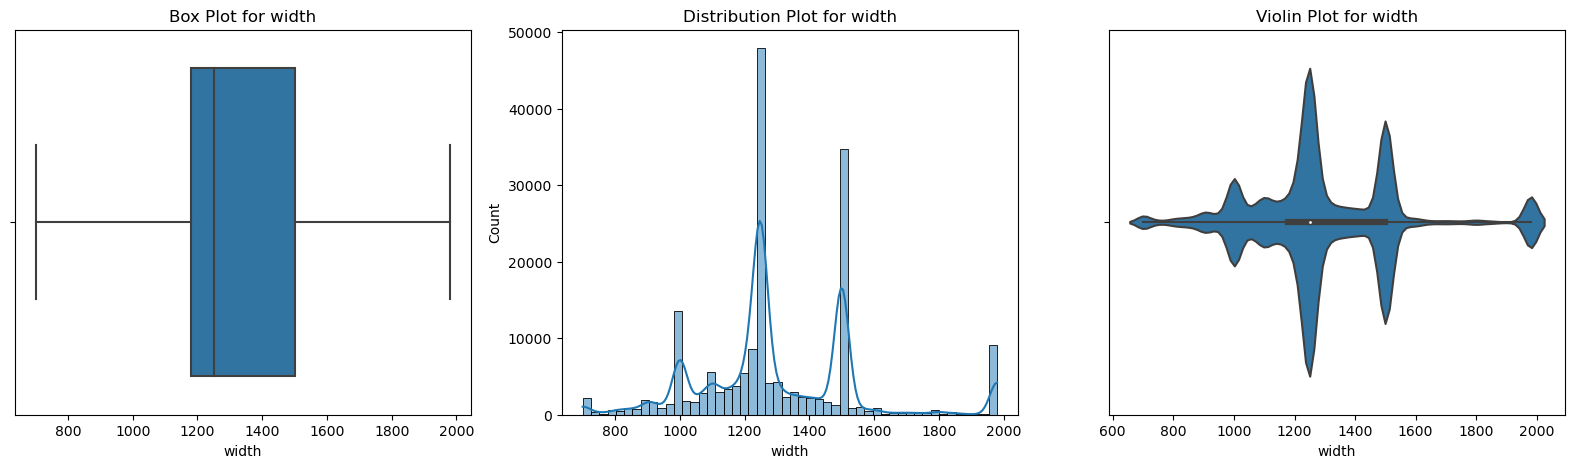

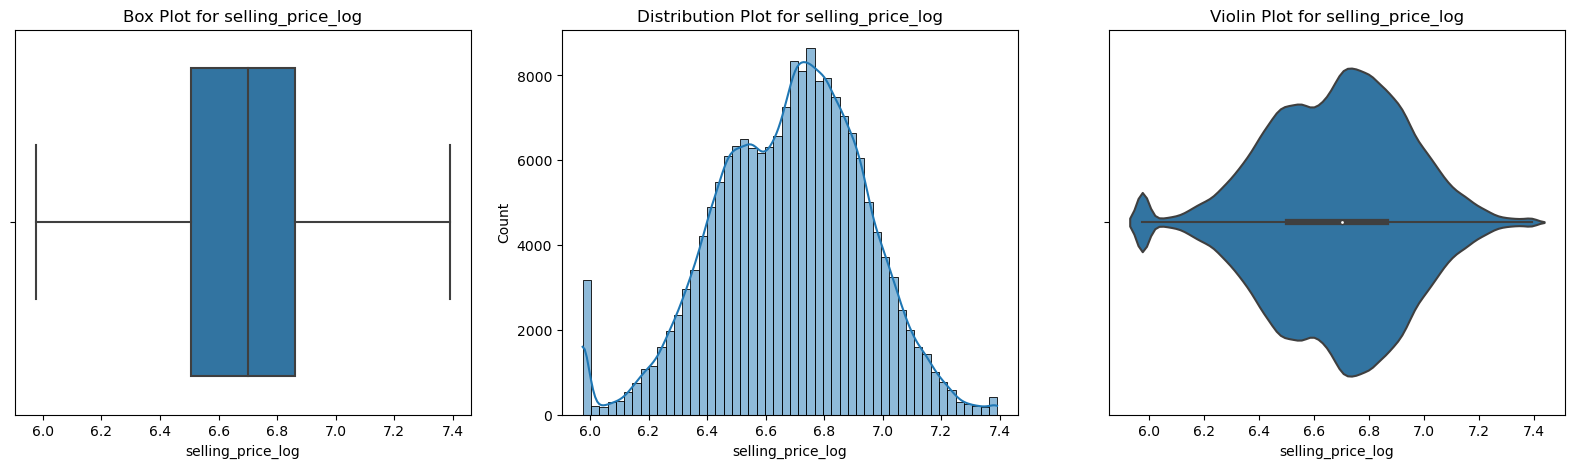

In [24]:
for i in ['quantity_tons_log', 'thickness_log', 'width', 'selling_price_log']:
    plot(df1, i)

<Axes: >

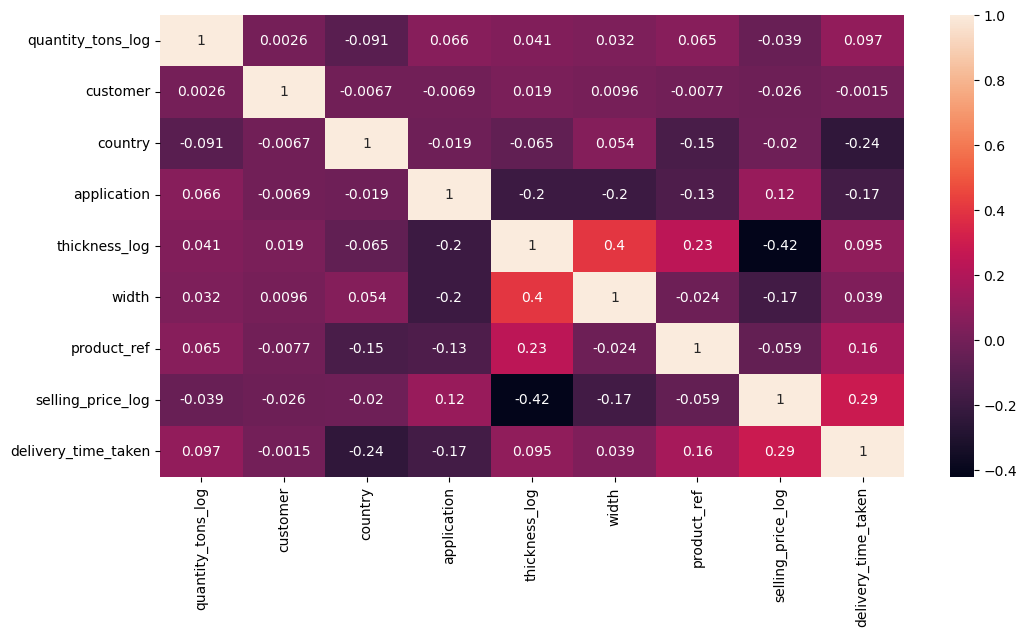

In [25]:
cor=df1[['quantity_tons_log', 'customer', 'country', 'application', 'thickness_log', 'width','product_ref', 'selling_price_log','delivery_time_taken']].corr()

plt.figure(figsize=(12,6))
sns.heatmap(cor,annot=True)

In [26]:
df_2=df1.copy()
df_2

,customer,country,status,item type,application,width,product_ref,delivery_time_taken,quantity_tons_log,thickness_log,selling_price_log
0,30156308.0,28.0,Won,W,10.0,1500.0,1670798778,91.0,3.991779,0.693147,6.749931
1,30202938.0,25.0,Won,W,41.0,1210.0,1668701718,0.0,6.643822,-0.223144,6.953684
2,30153963.0,30.0,Won,WI,28.0,952.0,628377,90.0,5.956169,-0.967584,6.468211
3,30349574.0,32.0,Won,S,59.0,1317.0,1668701718,90.0,5.310301,0.832909,6.643790
4,30211560.0,28.0,Won,W,10.0,1980.0,640665,31.0,6.666354,1.386294,6.357842
...,...,...,...,...,...,...,...,...,...,...,...
181668,30200854.0,25.0,Won,W,41.0,1220.0,164141591,1.0,4.629691,-0.040822,6.381816
181669,30200854.0,25.0,Won,W,41.0,1500.0,164141591,1.0,5.337954,-0.051293,6.378426
181670,30200854.0,25.0,Won,W,41.0,1250.0,164141591,1.0,1.443523,-0.342490,6.428105
181671,30200854.0,25.0,Won,W,41.0,1250.0,164141591,1.0,3.413291,-0.162519,6.398595


In [27]:
df_2["status"].value_counts()

status
Won                116012
Lost                34438
Not lost for AM     19573
Revised              4276
To be approved       4170
Draft                3140
Offered                53
Offerable              10
Wonderful               1
Name: count, dtype: int64

In [28]:
df_2["status"]= df_2["status"].map({'Won':1, 'Draft':2, 'To be approved':3, 'Lost':0, 'Not lost for AM':4,
                                'Wonderful':5, 'Revised':6, 'Offered':7, 'Offerable':8})
df_2['status'].unique()

array([1, 2, 3, 0, 4, 5, 6, 7, 8], dtype=int64)

In [29]:
df_2.head()

,customer,country,status,item type,application,width,product_ref,delivery_time_taken,quantity_tons_log,thickness_log,selling_price_log
0,30156308.0,28.0,1,W,10.0,1500.0,1670798778,91.0,3.991779,0.693147,6.749931
1,30202938.0,25.0,1,W,41.0,1210.0,1668701718,0.0,6.643822,-0.223144,6.953684
2,30153963.0,30.0,1,WI,28.0,952.0,628377,90.0,5.956169,-0.967584,6.468211
3,30349574.0,32.0,1,S,59.0,1317.0,1668701718,90.0,5.310301,0.832909,6.643790
4,30211560.0,28.0,1,W,10.0,1980.0,640665,31.0,6.666354,1.386294,6.357842


In [30]:
df_2['item type'].value_counts()

item type
W         105615
S          69236
PL          5660
Others       610
WI           524
IPL           27
SLAWR          1
Name: count, dtype: int64

In [31]:
df_2["item type"]= OrdinalEncoder().fit_transform(df_2[["item type"]])
df_2['item type'].unique()

array([5., 6., 3., 1., 2., 0., 4.])

In [32]:
df_2.head()

,customer,country,status,item type,application,width,product_ref,delivery_time_taken,quantity_tons_log,thickness_log,selling_price_log
0,30156308.0,28.0,1,5.0,10.0,1500.0,1670798778,91.0,3.991779,0.693147,6.749931
1,30202938.0,25.0,1,5.0,41.0,1210.0,1668701718,0.0,6.643822,-0.223144,6.953684
2,30153963.0,30.0,1,6.0,28.0,952.0,628377,90.0,5.956169,-0.967584,6.468211
3,30349574.0,32.0,1,3.0,59.0,1317.0,1668701718,90.0,5.310301,0.832909,6.643790
4,30211560.0,28.0,1,5.0,10.0,1980.0,640665,31.0,6.666354,1.386294,6.357842


In [33]:
def best_ML_algorithm(df,algorithms):
        x=df.drop(columns=['selling_price_log'],axis=1)
        y=df['selling_price_log']

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

        results={}

        for algorithm in algorithms:

                model=algorithm().fit(x_train,y_train)
                y_pred=model.predict(x_test)
                
                MAE=metrics.mean_absolute_error(y_test, y_pred)
                MSE=metrics.mean_squared_error(y_test, y_pred)
                RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
                r2 = metrics.r2_score(y_test, y_pred)

                results[algorithm.__name__] = {'Mean Absolute Error':MAE,'Mean Squared Error':MSE,'Root Mean Squared Error':RMSE,
                                        'R² score':r2}
                
        best_algorithm = max(results.items(), key=lambda item: item[1]['R² score'])[0]  
        
        return best_algorithm, results    

In [34]:
algorithms = [LinearRegression, DecisionTreeRegressor, ExtraTreesRegressor, RandomForestRegressor,
            GradientBoostingRegressor, XGBRegressor]
best_algorithm, results = best_ML_algorithm(df_2, algorithms)

results_df = pd.DataFrame(results).transpose()

print("**Evaluation Metrics for All Algorithms:**")
print(results_df.to_string())

print("**Best Algorithm:**",best_algorithm)

**Evaluation Metrics for All Algorithms:**
                           Mean Absolute Error  Mean Squared Error  Root Mean Squared Error  R² score
LinearRegression                      0.162836            0.045489                 0.213281  0.302651
DecisionTreeRegressor                 0.054053            0.010117                 0.100584  0.844903
ExtraTreesRegressor                   0.046350            0.005711                 0.075572  0.912448
RandomForestRegressor                 0.045924            0.005555                 0.074531  0.914842
GradientBoostingRegressor             0.118057            0.021458                 0.146487  0.671040
XGBRegressor                          0.079373            0.011073                 0.105230  0.830243
**Best Algorithm:** RandomForestRegressor


In [35]:
x=df_2.drop(columns=['selling_price_log'],axis=1)
y=df_2['selling_price_log']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

param_grid = { 
    'n_estimators' :[100,150],
    'max_depth': [10,20],     
    'min_samples_split': [2,4], 
    'min_samples_leaf': [1,2],
    'max_features'    : ['sqrt', 'log2', None] }


grid_search = GridSearchCV(estimator=RandomForestRegressor(),
                            param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(x_train, y_train)

grid_search.best_params_,grid_search.best_score_

({'max_depth': 20,
  'max_features': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 150},
 0.8953161026504356)

In [36]:
x=df_2.drop(columns=['selling_price_log'],axis=1)
y=df_2['selling_price_log']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

model_regressor = RandomForestRegressor(n_estimators=150,max_features=None,max_depth=20,min_samples_leaf=1,min_samples_split=2,random_state=42)
model_regressor.fit(x_train, y_train)

y_pred = model_regressor.predict(x_test)

# evaluation metrics 
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE = metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2 = metrics.r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {MAE}")
print(f"Mean Squared Error: {MSE}")
print(f"Root Mean Squared Error: {RMSE}")
print(f"R-squared: {r2}")

Mean Absolute Error: 0.04865270378066039
Mean Squared Error: 0.005851804110671627
Root Mean Squared Error: 0.07649708563515101
R-squared: 0.9102908140701418


In [37]:
feature_scores = pd.Series(model_regressor.feature_importances_, index=x_train.columns).sort_values(ascending=False)
feature_scores

product_ref            0.295669
delivery_time_taken    0.245778
status                 0.173055
country                0.072281
customer               0.067347
thickness_log          0.043546
quantity_tons_log      0.042078
application            0.023019
item type              0.019442
width                  0.017785
dtype: float64

In [38]:
with open('Regressor.pkl','wb') as files:
    pickle.dump(model_regressor,files)

In [39]:
with open('Regressor.pkl','rb') as files:
    predict_model=pickle.load(files)

pre=predict_model.predict(np.array([[30156308.0,28.0,1,5.0,10.0,1500.0,1670798778,91.0,3.991779,0.693147]]))
np.exp(pre[0])

779.8416406690988

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc

In [41]:
df_c=df_2[(df_2.status==1)|(df_2.status==0)]
df_c

,customer,country,status,item type,application,width,product_ref,delivery_time_taken,quantity_tons_log,thickness_log,selling_price_log
0,30156308.0,28.0,1,5.0,10.0,1500.0,1670798778,91.0,3.991779,0.693147,6.749931
1,30202938.0,25.0,1,5.0,41.0,1210.0,1668701718,0.0,6.643822,-0.223144,6.953684
2,30153963.0,30.0,1,6.0,28.0,952.0,628377,90.0,5.956169,-0.967584,6.468211
3,30349574.0,32.0,1,3.0,59.0,1317.0,1668701718,90.0,5.310301,0.832909,6.643790
4,30211560.0,28.0,1,5.0,10.0,1980.0,640665,31.0,6.666354,1.386294,6.357842
...,...,...,...,...,...,...,...,...,...,...,...
181668,30200854.0,25.0,1,5.0,41.0,1220.0,164141591,1.0,4.629691,-0.040822,6.381816
181669,30200854.0,25.0,1,5.0,41.0,1500.0,164141591,1.0,5.337954,-0.051293,6.378426
181670,30200854.0,25.0,1,5.0,41.0,1250.0,164141591,1.0,1.443523,-0.342490,6.428105
181671,30200854.0,25.0,1,5.0,41.0,1250.0,164141591,1.0,3.413291,-0.162519,6.398595


In [42]:
df_c['status'].value_counts()

status
1    116012
0     34438
Name: count, dtype: int64

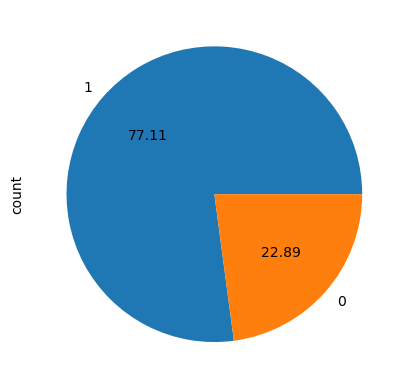

In [43]:
ax=df_c['status'].value_counts().plot.pie(autopct='%.2f')

Text(0.5, 1.0, 'over oversampling using smote')

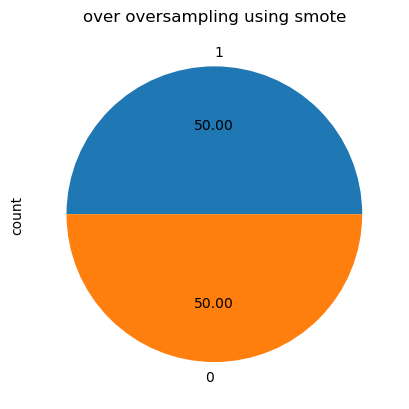

In [44]:
x=df_c.drop('status',axis=1)
y=df_c['status']

smote= SMOTE()

x_smote, y_smote = smote.fit_resample(x,y) 

ax=y_smote.value_counts().plot.pie(autopct='%.2f')
ax.set_title('over oversampling using smote')

In [45]:
def best_ML_class_algo(x_smote,y_smote,algorithms):
        
        x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.3, random_state=42)

        results={}

        for algorithm in algorithms:

                model=algorithm().fit(x_train,y_train)
                y_pred=model.predict(x_test)

                accuracy =metrics. accuracy_score(y_test, y_pred)
                precision =metrics. precision_score(y_test, y_pred)
                recall =metrics. recall_score(y_test, y_pred)
                f1 = metrics.f1_score(y_test, y_pred)

                results[algorithm.__name__] = {'Accuracy score': accuracy,'Precision': precision,'Recall': recall,'F1-score': f1}
                
        best_algorithm = max(results.items(), key=lambda item: item[1]['Accuracy score'])[0]  
        
        return best_algorithm, results  

In [46]:
algorithms = [ DecisionTreeClassifier, ExtraTreesClassifier, RandomForestClassifier,
            GradientBoostingClassifier, XGBClassifier]
best_algorithm, results = best_ML_class_algo(x_smote,y_smote, algorithms)

results_df = pd.DataFrame(results).transpose()

print("**Evaluation Metrics for All Algorithms:**")
print(results_df.to_string())

print("**Best Algorithm:**",best_algorithm)

**Evaluation Metrics for All Algorithms:**
                            Accuracy score  Precision    Recall  F1-score
DecisionTreeClassifier            0.957476   0.958105  0.956278  0.957191
ExtraTreesClassifier              0.977847   0.988044  0.967143  0.977482
RandomForestClassifier            0.975549   0.985653  0.964861  0.975146
GradientBoostingClassifier        0.800986   0.817892  0.771449  0.793992
XGBClassifier                     0.933844   0.953638  0.911227  0.931950
**Best Algorithm:** ExtraTreesClassifier


In [47]:
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators' :[50,100],
    'max_depth': [ 10,20,25],     
    'min_samples_split': [2, 4],  
    'min_samples_leaf': [1, 2]     }


model = ExtraTreesClassifier(random_state=42) 

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring="accuracy",n_jobs=-1)

grid_search.fit(x_train, y_train)

grid_search.best_params_,grid_search.best_score_

({'max_depth': 25,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 100},
 0.9626022051950504)

In [48]:
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.3, random_state=42)

model_classifier = ExtraTreesClassifier(n_estimators=100,max_depth=25,min_samples_leaf=1,min_samples_split=2)
model_classifier.fit(x_train, y_train)

y_pred = model_classifier.predict(x_test)

# evaluation metrics
print(metrics.confusion_matrix(y_test,y_pred))
print(metrics.classification_report(y_test,y_pred))

[[34647   356]
 [ 2068 32537]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     35003
           1       0.99      0.94      0.96     34605

    accuracy                           0.97     69608
   macro avg       0.97      0.97      0.97     69608
weighted avg       0.97      0.97      0.97     69608



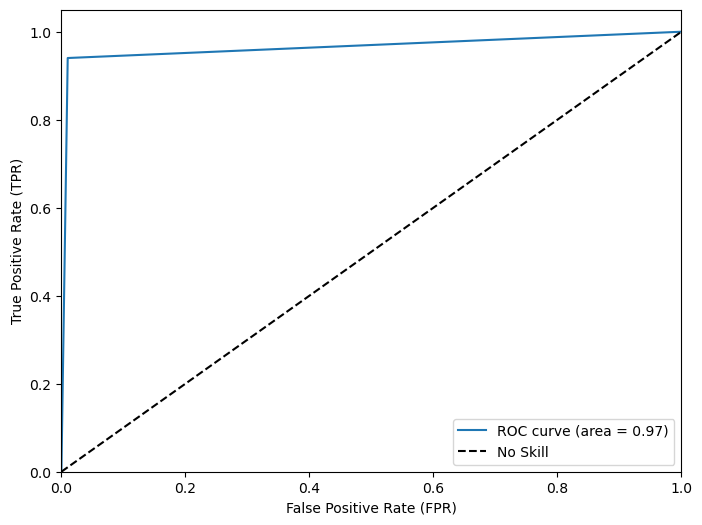

In [49]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
auc_curve=auc(x=fpr,y=tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_curve)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc="lower right")

In [50]:
feature_scores = pd.Series(model_classifier.feature_importances_, index=x_train.columns).sort_values(ascending=False)
feature_scores

delivery_time_taken    0.180941
item type              0.128010
customer               0.127471
country                0.114709
application            0.106711
quantity_tons_log      0.095499
selling_price_log      0.076323
product_ref            0.063485
thickness_log          0.062964
width                  0.043886
dtype: float64

In [51]:
with open('Classifier.pkl','wb') as  files:
    pickle.dump(model_classifier,files)

In [52]:
with open('Classifier.pkl','rb') as files:
    clas_model=pickle.load(files)

cla = clas_model.predict( np.array([[30156308.0,28.0,5.0,10.0,1500.0,1670798778,91.0,3.991779,0.693147,6.749931]]))
if cla[0] == 1:
    print('Won')
else:
    print('Lose')

Won
